In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [2]:
import random

In [3]:
# b_n = np.array([50, 60, 40, 55, 45])  # Battery capacities (MWh)
# s_n = np.array([1, 1.2, 1.5, 1.1, 1.3])  # Satisfaction parameters

In [4]:
# Problem-specific parameters
N = 15  # Number of PEVGs
C = 99  # Grid capacity (MWh)

b_n = [] # Battery capacities (MWh)
s_n = [] # Satisfaction parameters

for i in range(N):
    b_n.append( random.randint(35 , 65) )
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)
    

In [5]:
print(b_n)
print(s_n)

[37 45 45 65 52 52 39 45 59 58 48 55 35 47 58]
[1.47147797 1.68030597 1.60172258 1.79337133 1.35225361 1.55229533
 1.27607212 1.17448411 1.49972977 1.30688339 1.07136708 1.78279573
 1.57223197 1.87723935 1.01996048]


In [6]:
# Define the MOO problem
class EVChargingProblem(ElementwiseProblem):
    def __init__(self):
        # Define variables: p (1) + x_n (N), 3 objectives, 1 constraint
        super().__init__(n_var=N + 1,  # p + x_1, ..., x_N
                         n_obj=2,      # Revenue, Utility, -Wastage
                         n_constr=1,   # Total demand <= C
                         xl=np.array([20] + [0] * N),  # Lower bounds: p >= 0, x_n >= 0
                         xu=np.array( [50] + [ min( b_n[i], C) for i in range(N) ] ))  # Upper bounds: p <= max(b_n), x_n <= b_n

    def _evaluate(self, X, out, *args, **kwargs):
        # Extract variables
        p = X[0]  # Price
        x_n = X[1:]  # Demands

        # Objective 1: Maximize revenue (h_1)
        revenue = p * np.sum(x_n)
        
        # Objective 2: Maximize aggregate utility (h_2)
        utility = np.sum(b_n * x_n - 0.5 * s_n * x_n**2 - p * x_n)
        
        # Objective 3: Minimize wastage (converted to maximize -h_3)
        wastage = C - np.sum(x_n)
        
        # Objectives (pymoo minimizes, so negate maximizations)
        out["F"] = [-revenue, -utility]  # Minimize [-h_1, -h_2]
        # wastage
        
        # Constraint: sum(x_n) <= C ( Converted to g(x) <= 0 )
        out["G"] = [-wastage]

In [7]:
# Initialize NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,  # Population size
    n_offsprings=50,  # Number of offspring per generation
    eliminate_duplicates=True
)

In [8]:

# Define termination criteria (e.g., 200 generations)
from pymoo.termination import get_termination
termination = get_termination("n_gen", 200)

In [9]:
# Solve the problem
res = minimize(EVChargingProblem(),
               algorithm,
               termination,
               seed=42,
               verbose=False)

In [10]:
# Extract results
X = res.X  # Decision variables (p, x_1, ..., x_N)
# X

In [11]:
F = res.F  # Objective values (negated revenue, negated utility, wastage)
# F

In [12]:
revenue = -F[:, 0]
# revenue

In [13]:
utility = -F[:, 1]
# utility

In [14]:
# Print sample solutions
# print("Sample Solutions:")
# for i in range(min(5, len(X))):  # Print first 5 solutions
#     print(f"Solution {i+1}:")
#     print(f"  p = {X[i, 0]:.2f} USD/MWh")
#     print(f"  x_n = {X[i, 1:]} MWh")
#     print(f"  Revenue = {revenue[i]:.2f} USD")
#     print(f"  Utility = {utility[i]:.2f}")
#     print(f"  Wastage = {wastage[i]:.2f} MWh\n")

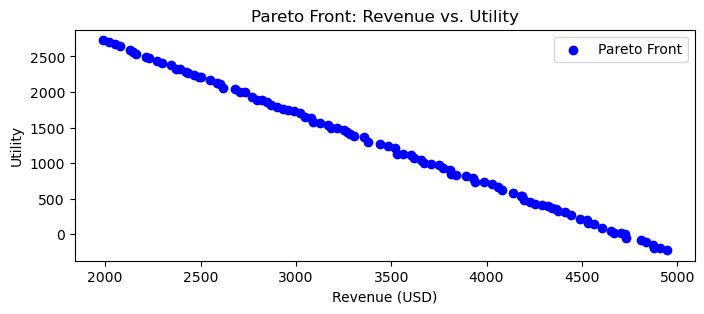

In [15]:
# Plot the Pareto front
fig = plt.figure(figsize=(8 , 3))
ax = fig.add_subplot(111)
sc = ax.scatter(revenue, utility, c='blue', label='Pareto Front')
ax.set_xlabel('Revenue (USD)')
ax.set_ylabel('Utility')
ax.set_title('Pareto Front: Revenue vs. Utility')
plt.legend()
plt.show()